# **run load_data.ipynb BEFORE running this!**

In [142]:
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s = {
    'problem'           : "regression",
    'approach'          : "metric learning",
    'method'            : "non-parametric",
    'algorithm'         : "triplet network",
    'goal'              : "learn a distribution using few samples from it",
    'input'             : "samples from a distribution",
    'input type'        : "vectors",
    'input meaning'     : "spectrum", 
    'output'            : "samples from a distribution",
    'output type'       : "one number",
    'output meaning'    : "temperature or pressure, depending on distribution",
    'support-query ratio': 0.8,
    'task size'         : 5,
    'learning rate'     : 1e-4,
    'input dimension'   : 10000,
    'output dimension'  : 1,
    'feature dimension' : 300,
    'epoch'             : 1000,
    'epoch development' : 4,
    'data'              : 'pressure_230516_discrete',
    'cross validation round': 16,
    'cross validation round-development' : 3,
    'batch size'        : 64,
    'best model folder' : 'triplet_best_model/'
}
# https://arxiv.org/pdf/1412.6622.pdf
print(f"data: {s['data']}")

data: pressure_230516_discrete


In [143]:
import data_accessor as acc
data_names_list = [
    'temperature_230509_discrete',
    'pressure_230516_discrete'
    ]
data_dictionary = acc.setup(data_names_list)

loading temperature_230509_discrete__________________________
	input shape (number, dimension): (6000, 10000)
	label shape (number, dimension): (6000, 1)
	there are 16 folds
	4200 for training, 600 for validating, 1200 for testing
loading pressure_230516_discrete__________________________
	input shape (number, dimension): (5000, 10000)
	label shape (number, dimension): (5000, 1)
	there are 16 folds
	3500 for training, 500 for validating, 1000 for testing


In [144]:
# task layout July 24, 2023

# TODO: Implement triplet network for regression

In [145]:
import torch.nn as nn
class TripletNetwork(torch.nn.Module):
    """ Input: pos, neg, anchor, anchor_label
        Output: pos_prediction, neg_prediction"""
    def __init__(self, device, input_dimension, feature_dimension, output_dimension):
        super().__init__()
        self.input_dimension = input_dimension
        self.feature_dimension = feature_dimension
        self.output_dimension = output_dimension
        self.device = device
        self.feature_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.input_dimension, 3000),
            nn.ReLU(),
            torch.nn.Linear(3000, 600),
            nn.ReLU(),
            torch.nn.Linear(600, 600),
            nn.ReLU(),
            torch.nn.Linear(600, 300),
            nn.ReLU(),
            torch.nn.Linear(300, self.feature_dimension)
        )
        self.auxiliary_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dimension, 100),
            nn.ReLU(),
            torch.nn.Linear(100, 100),
            nn.ReLU(),
            torch.nn.Linear(100, self.output_dimension)
        )
        self.to(device)
        self.float()
    def forward(self, pos, neg, anchor, anchor_label):
        feature_pos = self.feature_sequential(pos)
        feature_neg = self.feature_sequential(neg)
        feature_anchor = self.feature_sequential(anchor)
        feature_space_difference_pos_anchor = feature_pos - feature_anchor
        feature_space_difference_neg_anchor = feature_neg - feature_anchor
        label_space_difference_pos_anchor = self.auxiliary_sequential(feature_space_difference_pos_anchor)
        label_space_difference_neg_anchor = self.auxiliary_sequential(feature_space_difference_neg_anchor)
        prediction_pos = anchor_label + label_space_difference_pos_anchor
        prediction_neg = anchor_label + label_space_difference_neg_anchor
        return prediction_pos, prediction_neg

In [146]:
from tools import SaveBestModel, PatienceEarlyStopping, Scheduler, plot_losses
class Manager:
    """ DOES: train & evaluate a Siamese network
        """
    def __init__(self, epoch, cross_validation_round):
        self._network = TripletNetwork(device, s['input dimension'], s['feature dimension'], s['output dimension'])
        self._network.apply(self.initializer)
        self._learning_rate = s['learning rate']
        self._optimizer = torch.optim.Adam(
            params=self._network.parameters(), lr=self._learning_rate,
            weight_decay=3e-3)
        self._energy = nn.MSELoss()
        self._train_loss = []
        self._valid_loss = []
        self._test_loss = []
        self._epoch = epoch
        self._stopper = PatienceEarlyStopping(patience=5, min_delta=5e-7)
        self._cross_validation_round = cross_validation_round
        self._saver = SaveBestModel(s['best model folder'])
        self._scheduler = Scheduler(optimizer=self._optimizer, 
            minimum_learning_rate=1e-6, patience=5, factor=0.5)
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def _step(self, job):
        pos, pos_label, neg, neg_label, anchor, anchor_label = job
        pos_prediction, neg_prediction = self._network(pos, neg, anchor, anchor_label)
        pos_loss = self._energy(pos_prediction, pos_label)
        neg_loss = self._energy(neg_prediction, neg_label)
        loss = (pos_loss + neg_loss) / 2.0
        return loss     
    def train(self, train_dataloader, valid_dataloader):
        """ DOES: calculate loss from tasks
            NOTE: we have a BATCH of tasks here """
        for e in range(self._epoch):
            batch_train_loss = []
            for _, batch in enumerate(train_dataloader): 
                self._optimizer.zero_grad()
                loss = self._step(batch)
                loss.backward()
                self._optimizer.step()
                batch_train_loss.append(loss.item())
            self._train_loss.append(np.mean(batch_train_loss))
            batch_valid_loss = []
            with torch.no_grad():
                for _, batch in enumerate(valid_dataloader): 
                    loss = self._step(batch)
                    batch_valid_loss.append(loss.item())
            self._valid_loss.append(np.mean(batch_valid_loss))
            # saving, early stopping, scheduler for EACH epoch!
            self._saver(current_loss=np.mean(batch_valid_loss), 
                  model=self._network, 
                  round=self._cross_validation_round
                  )
            self._scheduler(np.mean(batch_valid_loss))
            self._stopper(np.mean(batch_valid_loss))
            if self._stopper.early_stop == True:
                print(f"EARLY STOPPING @ epoch {e}")
                break
        # summary printout, after we're done with epochs
        print(f"min train loss: {np.min(self._train_loss)}")
        print(f"min valid loss: {np.min(self._valid_loss)}")
        plot_losses(self._train_loss, self._valid_loss, self._cross_validation_round)
        return np.min(self._valid_loss)
    def test(self, test_dataloader):
        with torch.no_grad():
            batch_test_loss = []
            for _, batch in enumerate(test_dataloader): 
                loss = self._step(batch)
                batch_test_loss.append(loss.item())
            self._test_loss.append(np.mean(batch_test_loss)) 
        return np.min(self._test_loss)

In [147]:
import random
class TripletDataset(torch.utils.data.TensorDataset):
    """ input: input data
        label: label
        indices: indices used e.g. training indices
        """
    def __init__(self, input, label, indices, device):
        self.input = torch.Tensor(input).to(device)
        self.label = torch.Tensor(label).to(device)
        self.access_indices = indices
        self.indices = range(len(self.access_indices))
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, index): 
        index = self.access_indices[index]
        anchor_index = random.choice(self.access_indices)
        neg_index = random.choice(self.access_indices)
        pos = self.input[index]
        pos_label = self.label[index]
        anchor = self.input[anchor_index]
        anchor_label = self.label[anchor_index]
        neg = self.input[neg_index]
        neg_label = self.label[neg_index]
        return pos, pos_label, neg, neg_label, anchor, anchor_label
    

data: pressure_230516_discrete
CV round 0
EARLY STOPPING @ epoch 32
min train loss: 8.47424238930795e-05
min valid loss: 7.09227815605118e-05


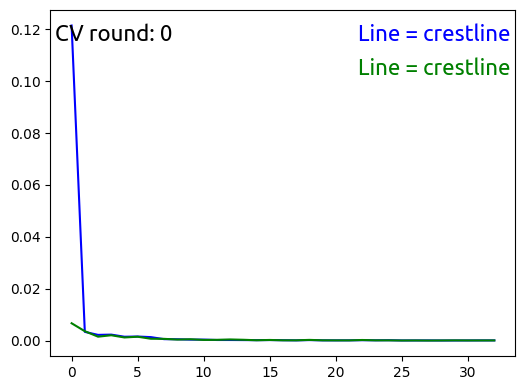

CV round 1
EARLY STOPPING @ epoch 36
min train loss: 7.588435665556146e-05
min valid loss: 8.371656213057577e-05


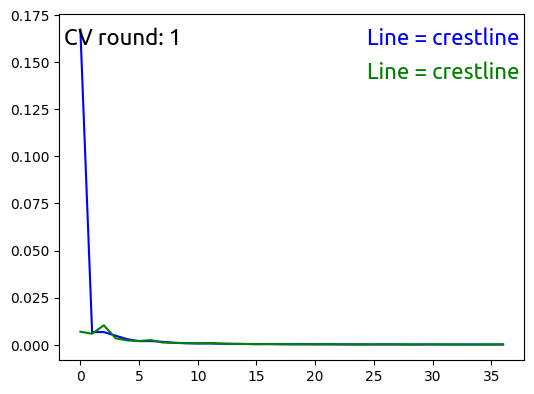

CV round 2
EARLY STOPPING @ epoch 38
min train loss: 9.610602567342788e-05
min valid loss: 7.440344870701665e-05


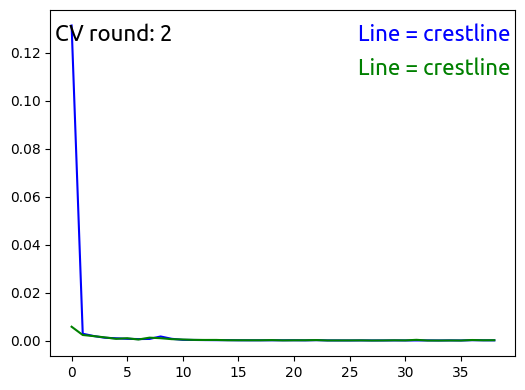

CV round 3
EARLY STOPPING @ epoch 39
min train loss: 7.565003959991208e-05
min valid loss: 7.331895722018089e-05


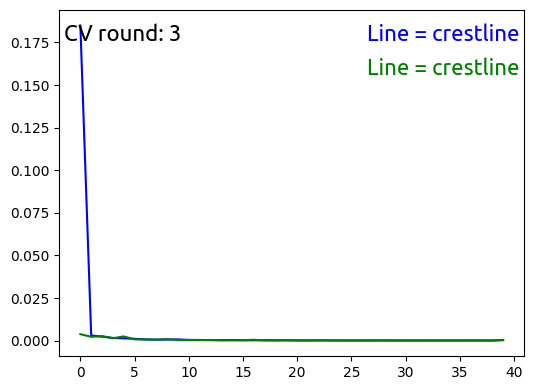

CV round 4
EARLY STOPPING @ epoch 30
min train loss: 0.00010352153754369779
min valid loss: 8.727668955543777e-05


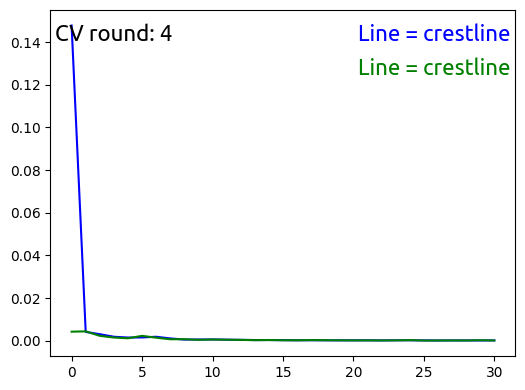

CV round 5
EARLY STOPPING @ epoch 35
min train loss: 0.00011170396253212609
min valid loss: 8.77294723977684e-05


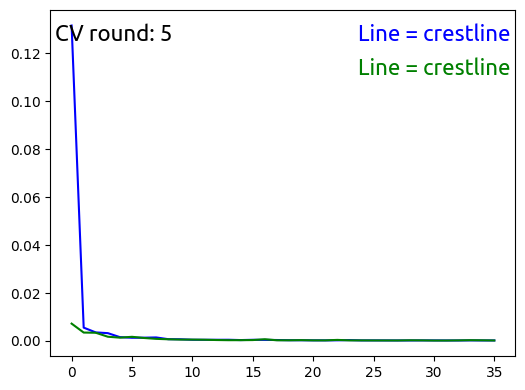

CV round 6
EARLY STOPPING @ epoch 43
min train loss: 6.997337702407756e-05
min valid loss: 6.850417730674963e-05


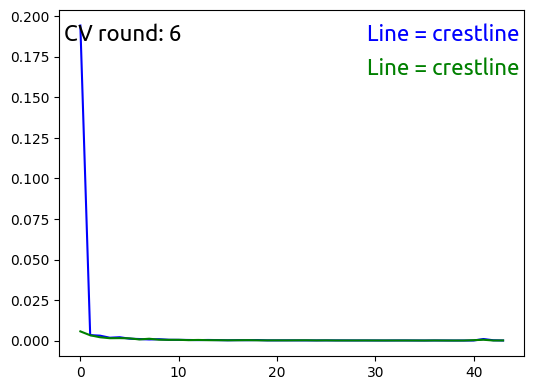

CV round 7
EARLY STOPPING @ epoch 30
min train loss: 8.881700176227076e-05
min valid loss: 9.669283190305578e-05


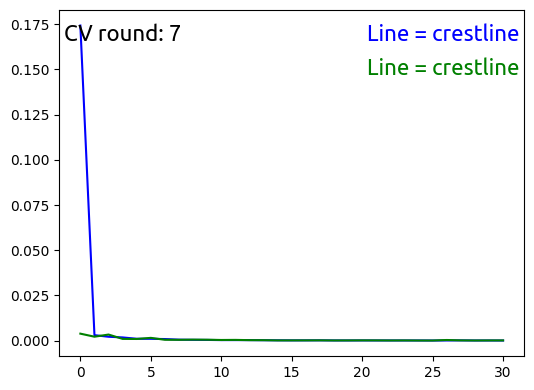

CV round 8
EARLY STOPPING @ epoch 36
min train loss: 8.843161042684435e-05
min valid loss: 8.263535801233957e-05


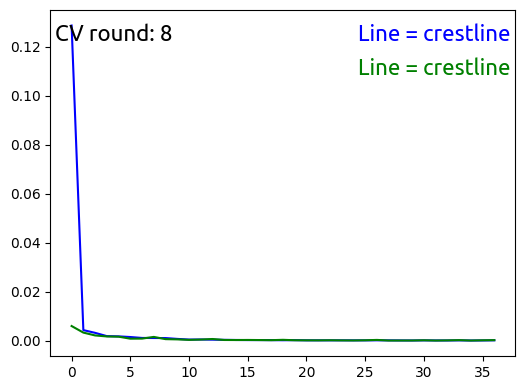

CV round 9
EARLY STOPPING @ epoch 39
min train loss: 7.824741213963451e-05
min valid loss: 7.28750746930018e-05


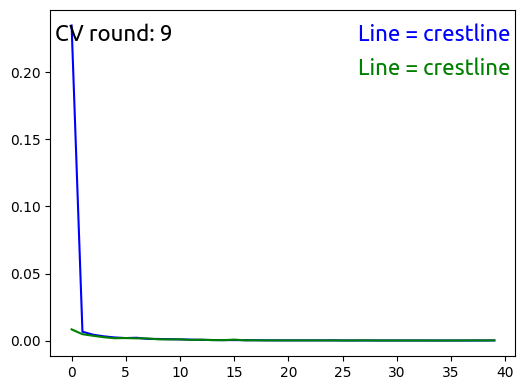

CV round 10
EARLY STOPPING @ epoch 35
min train loss: 7.594696084693582e-05
min valid loss: 9.466289611737011e-05


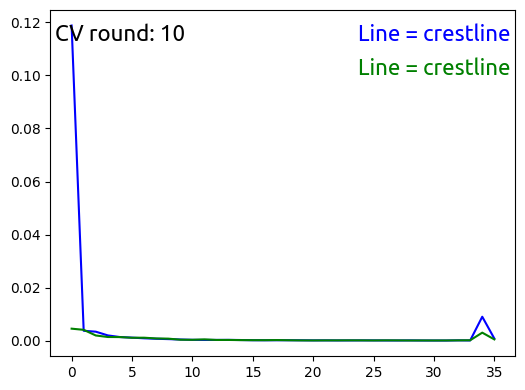

CV round 11
EARLY STOPPING @ epoch 24
min train loss: 0.00010628102529815144
min valid loss: 0.0001098148777600727


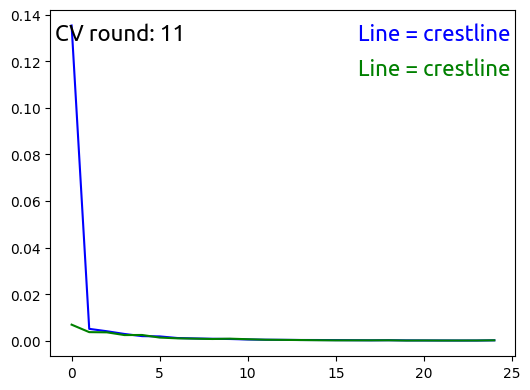

CV round 12
EARLY STOPPING @ epoch 31
min train loss: 9.143345338419418e-05
min valid loss: 9.880844754661666e-05


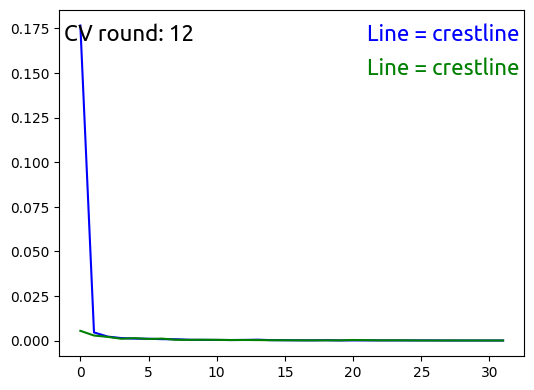

CV round 13
EARLY STOPPING @ epoch 38
min train loss: 7.773908509989269e-05
min valid loss: 7.692203962506028e-05


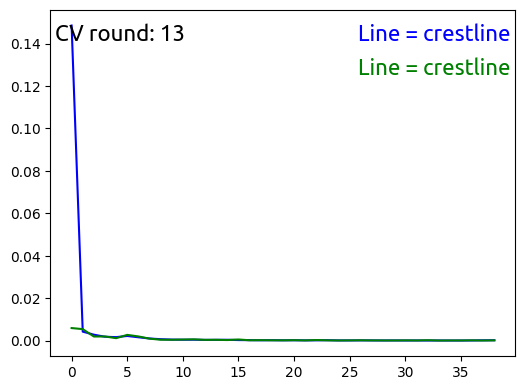

CV round 14
EARLY STOPPING @ epoch 36
min train loss: 8.939520504844206e-05
min valid loss: 8.433910716121318e-05


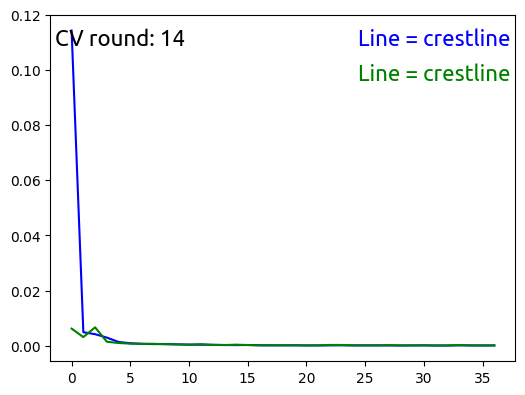

CV round 15
EARLY STOPPING @ epoch 36
min train loss: 8.273381688261659e-05
min valid loss: 7.301423465833068e-05


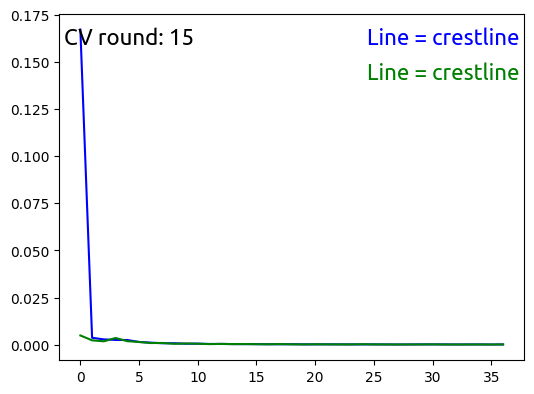



best model is: CV=6.pth with 6.850417730674963e-05
The aggregate performance is: mean 8.347730977220635e-05, std 1.1441963568485907e-05


In [148]:
from torch.utils.data import DataLoader
from tools import SaveBestCrossValidationModel

CV_saver = SaveBestCrossValidationModel(s['best model folder'])
test_indices = data_dictionary[s['data']]['test indices']
epoch = s['epoch']
print(f"data: {s['data']}")
cross_validation_loss = []
for cross_validation_round, (train, valid) in enumerate(zip(
    data_dictionary[s['data']]['train indices'],
    data_dictionary[s['data']]['valid indices'])):
    if cross_validation_round < s['cross validation round']:
        print(f"CV round {cross_validation_round}")
        network_object = Manager(epoch, cross_validation_round)
        valid_loss = network_object.train(
            DataLoader(TripletDataset(
            data_dictionary[s['data']]['data'],
            data_dictionary[s['data']]['label'],
            data_dictionary[s['data']]['train indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']),
            DataLoader(TripletDataset(
            data_dictionary[s['data']]['data'],
            data_dictionary[s['data']]['label'],
            data_dictionary[s['data']]['valid indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']))
        CV_saver(current_loss=valid_loss, round=cross_validation_round)
        cross_validation_loss.append(valid_loss)
print()
print(f"\nbest model is: {CV_saver.best_model_name} with {CV_saver.current_best_loss}")
print(f"The aggregate performance is: mean {np.mean(cross_validation_loss)}, std {np.std(cross_validation_loss)}")

In [149]:
network_object._network.load_state_dict(torch.load(s['best model folder'] + CV_saver.best_model_name))
test_loss = network_object.test(
            DataLoader(TripletDataset(
            data_dictionary[s['data']]['data'],
            data_dictionary[s['data']]['label'],
            data_dictionary[s['data']]['test indices'],
            device=device,), shuffle=False, batch_size=s['batch size']))
print(f"testing loss: {test_loss}")

testing loss: 0.00010500419512027293
